# Free Energy Calculations
In this Notebook, we want to have a short glimpse on Free Energy Calculations. This is a hot topic in computational simulation area, as free energies can be used to estimate e.g. the likelihood of a molecule inhibiting a protein and therefore the usefulness of a compound as drug candidate. But free energy can be used of course in many more contexts, also for solubility, etc..

Here we calculate the Gibbs Free Energy.

Gibbs Energy:   
$ G_x = V_x - T_x  S_x $

With that we can calculate the free energy difference:
$\Delta G_{ij} = G_j - G_i$ 


In this notebook we will cover following methods:
* pertubation

  * FEP
  * BAR
* linear coupling
    * TI
* exponential coupling
    * EDS
* hybrid coupling
    * $\lambda$-EDS
* Enhanced Sampling methods:
    * Conveyor Belt
    * RE-EDS


In [1]:

#but first some imports:

##System Path
import os, sys
path = os.getcwd()+"/.."
sys.path.append(path)

##basics
import numpy as np
from matplotlib import pyplot as plt

##Ensembler
from ensembler.analysis.freeEnergyCalculation import zwanzigEquation, threeStateZwanzigReweighting, bennetAcceptanceRatio

from ensembler.potentials import OneD as pot
from ensembler.integrator.stochastic import metropolisMonteCarloIntegrator
from ensembler.system.basic_system import system
from ensembler.system.perturbed_system import perturbedSystem
from ensembler.system.eds_system import edsSystem

from ensembler.visualisation.plotSimulations import static_sim_plots

#Benchmarking parameters
simulation_steps_total_per_approach = 10000
rand=0.1

## Setting up a System
We are now going to Setup a system, for the Free Energy Calculations. For this Notebook, we want to keep it simple. Therefore two 1D-Harmonic Oscillators with different shifted minima and force constants shall be perfect for us.



(<Figure size 432x288 with 1 Axes>, None)

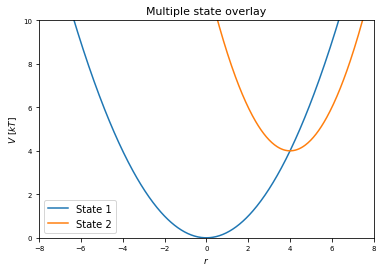

In [2]:
#Build System
#System Parameters:
yoff1 = 0
xoff1 = 0
force_constant = k1 =0.5

entropic_difference = k2 = 1
potential_difference = yoff2 = 4#1
phase_space_distance = xoff2 = 4

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#Visualize
from ensembler.visualisation.plotPotentials import multiState_overlays

multiState_overlays([h1,h2])

## Analyctical Solution
The Analytical solution for this system can be calculated as follows: 

Gibbs Energy:   
$ G_x = V_x - T_x  S_x $

For a harmonic Oscillator the entropy term can be formulated as:
$G_x = V_x - \frac{1}{\beta} log(\sqrt{\frac{2 \pi}{k_X \beta}})$


The final difference is:
$\Delta G_{ij} = G_j - G_i$ 


In [3]:
#Analytical Solution
beta = 1 # beta is in kT

G_1 = yoff1 -(1/beta) * np.log(np.sqrt((2*np.pi)/(k1*beta)))
G_2 = yoff2 -(1/beta) * np.log(np.sqrt((2*np.pi)/(k2*beta)))
dG_expected = G_2-G_1

print("expected dG: ", dG_expected)


expected dG:  4.346573590279973


## Pertubation Methods - BAR/Zwanzig

### Sampling
    



{'bodies': [<matplotlib.collections.PolyCollection object at 0x000001E30B997208>]}



{'bodies': [<matplotlib.collections.PolyCollection object at 0x000001E30B612A88>]}


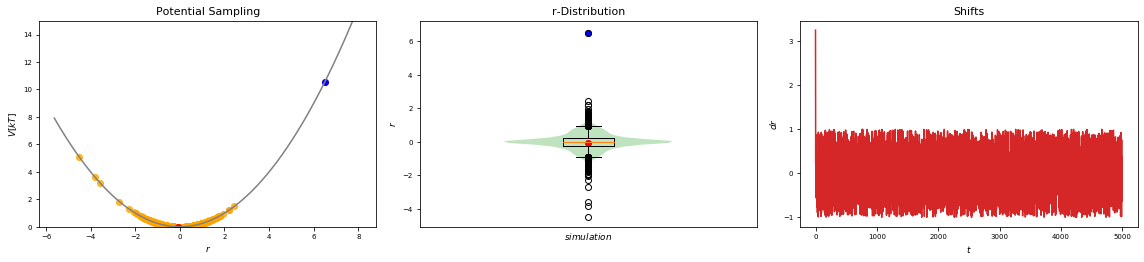

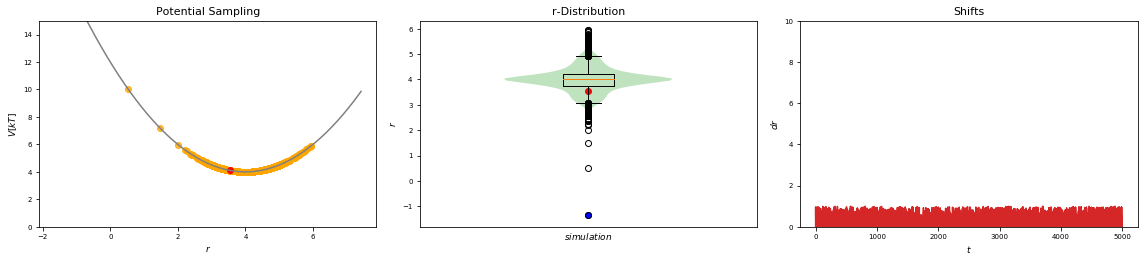

In [6]:
#Simulate the two states:
steps = simulation_steps_total_per_approach//2
equilibration_steps = 100

##Build Systems
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
system1 = system(potential=h1, integrator=integrator)
system2 = system(potential=h2, integrator=integrator)


system1.simulate(steps, withdrawTraj=True, initSystem=True)
state1_traj = system1.getTrajectory()
_ = static_sim_plots(system1, y_lim_Pot=[0,15])

system2.simulate(steps, withdrawTraj=True, initSystem=True)
state2_traj = system2.getTrajectory()
_ = static_sim_plots(system2, y_lim_Pot=[0,15])
plt.ylim([0,10])
pass

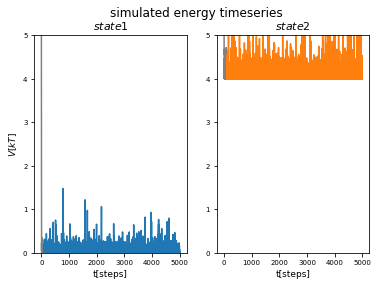

In [15]:
#Visualisation
fig, axes = plt.subplots(ncols=2)
axes[0].plot(list(state1_traj.index[:equilibration_steps]), state1_traj.totEnergy[:equilibration_steps], c="grey")
axes[0].plot(list(state1_traj.index[equilibration_steps:]), state1_traj.totEnergy[equilibration_steps:], c="C0")
axes[0].set_ylim([0,5])
axes[0].set_title("$state1$")
axes[0].set_xlabel("t[steps]")
axes[0].set_ylabel("$V[kT]$")

axes[1].plot(list(state2_traj.index[:equilibration_steps]), state2_traj.totEnergy[:equilibration_steps], c="grey")
axes[1].plot(list(state2_traj.index[equilibration_steps:]), state2_traj.totEnergy[equilibration_steps:], c="C1")
axes[1].set_ylim([0,5])
axes[1].set_title("$state2$")
axes[1].set_xlabel("t[steps]")
fig.suptitle("simulated energy timeseries")

pass

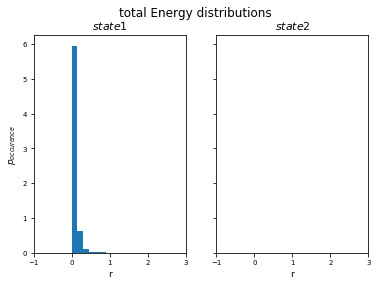

In [16]:
#Visualisation
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
axes[0].hist(state1_traj.totEnergy[equilibration_steps:], color="C0", density=True)
axes[0].set_title("$state1$")
axes[0].set_xlim([-1,3])
axes[0].set_xlabel("r")
axes[0].set_ylabel("$p_{occurence}$")

axes[1].hist(state2_traj.totEnergy[equilibration_steps:], color="C1", density=True)
axes[1].set_title("$state2$")
axes[1].set_xlim([-1,3])
axes[1].set_xlabel("r")

fig.suptitle("total Energy distributions")

pass

### Analysis
#### Zwanzig Equation

In [17]:
V1=state1_traj.totEnergy[equilibration_steps:]
V2=state2_traj.totEnergy[equilibration_steps:]

zwanz = zwanzigEquation(kT=True)
dF_zwanzig = zwanz.calculate(Vi=V1, Vj=V2)

print("Expected Result: ", dG_expected)
print("Zwanzig Result: ", dF_zwanzig)
print()
print("Difference:", dF_zwanzig - dG_expected)


Expected Result:  4.346573590279973
Zwanzig Result:  4.032245606057596

Difference: -0.31432798422237695


#### Bennet Acceptance Ratio (BAR)

In [18]:
#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)

bar = bennetAcceptanceRatio(kT=True)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22)

print()
print("Expected Result: ", dG_expected)
print("BAR Result: ", dF_bar)
print()
print("Difference:", dF_bar - dG_expected)


TypeError: <lambda>() takes 1 positional argument but 2 were given

# Linear Coupling Method - Thermodynamic Integration (TI)

## Sampling

Text(0.5, 1.0, 'Sampled Potentials')

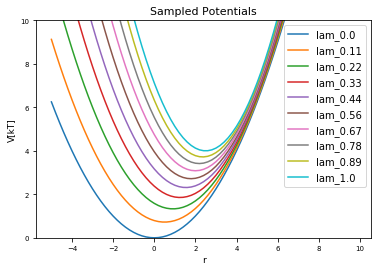

In [9]:
#Build Potential
V_perturbed = pot.linearCoupledPotentials(Va=h1, Vb=h2)

#Visualize
lambda_points = 10
positions = np.arange(-5,10, 0.2)
lambda_windows=np.linspace(0,1, lambda_points)
for lam in lambda_windows:
    V_perturbed.set_lam(lam)
    ene =  V_perturbed.ene(positions)
    plt.plot(positions,ene, label="lam_"+str(round(lam, 2)))
    
plt.legend()
plt.ylim([0,10])
plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [10]:
steps = simulation_steps_total_per_approach//lambda_points
equilibration_steps = 30

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
system = perturbedSystem(potential=V_perturbed, integrator=integrator)

system_trajs = {}
for lam in lambda_windows:
    system.set_lam(lam)
    system.simulate(steps, withdrawTraj=True, initSystem=True)
    system_trajs.update({lam: system.trajectory})


### Analysis

In [11]:
system_trajs[lam].head()
 

,position,temperature,totEnergy,totPotEnergy,totKinEnergy,dhdpos,velocity,lam,dhdlam
0,2.6386324050203775,298.0,3.757497,3.757497,NaN,0.11153364984424408,NaN,0.888889,2.269014
1,-9.243032160397771,298.0,72.949402,72.949402,NaN,0.09836772176279762,NaN,1.000000,51.590991
2,-9.160609016873124,298.0,71.984901,71.984901,NaN,0.08242314352464597,NaN,1.000000,51.005712
3,-8.728788875483957,298.0,67.042850,67.042850,NaN,0.43182014138916636,NaN,1.000000,47.994911
4,-8.545871731107407,298.0,65.005641,65.005641,NaN,0.18291714437655038,NaN,1.000000,46.747660


Text(0.5, 0.98, 'Lambda points')

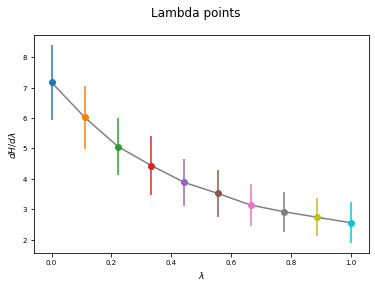

In [12]:
fig, axes = plt.subplots(ncols=1)

lam_stats = {}
for lam in system_trajs:
    lam_mean, lam_std = np.mean(system_trajs[lam].dhdlam[equilibration_steps:]), np.std(system_trajs[lam].dhdlam[equilibration_steps:])
    lam_stats.update({lam:{"mean":lam_mean, "std": lam_std}})
    
    axes.scatter(lam, lam_mean)
    axes.errorbar(lam, lam_mean, lam_std)

axes.plot(sorted(lam_stats), [lam_stats[x]["mean"] for x in sorted(lam_stats)], color="grey", zorder=-1)
axes.set_ylabel("$dH/d\lambda$")
axes.set_xlabel("$\lambda$")

fig.suptitle("Lambda points")


In [13]:
from scipy import integrate

lam = list(sorted(lam_stats.keys()))
means = [lam_stats[x]['mean'] for x in lam] 
stds = [lam_stats[x]['std'] for x in lam] 


In [14]:
dF_trapez = integrate.trapz(x=lam, y=means)
dF_err = integrate.trapz(x=lam, y=stds)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_trapez, "+-", dF_err)
print()
print("Difference:", dF_trapez - dG_expected)



Expected Result:  4.346573590279973
trapez Rule Result:  4.060479822812554 +- 0.821567063005831

Difference: -0.28609376746741866


In [15]:
# or kepschler Weinfass method @gerhard
dF_simpson = integrate.simps(x=lam, y=means)
dF_err = integrate.simps(x=lam, y=stds)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_simpson, "+-", dF_err)
print()
print("Difference:", dF_simpson - dG_expected)


Expected Result:  4.346573590279973
trapez Rule Result:  4.0514364728969205 +- 0.8196818412558706

Difference: -0.29513711738305215


## Exponentially Coupled - Enveloping Distribution Sampling (EDS) - BAR/RewightedFEP

Text(0.5, 1.0, 'Sampled Potentials')

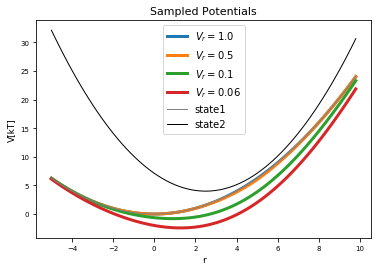

In [4]:
#Build Potential
s=1
V_eds = pot.exponentialCoupledPotentials(Va=h1, Vb=h2, s=s)

s1 = 1.0
s2 = 0.5
s3 = 0.1
s4 = 0.06

#Visualize
positions = np.arange(-5,10, 0.2)

V_eds.set_s(s1)
plt.plot(positions,V_eds.ene(positions), lw=3, label="$V_r="+str(s1)+"$")
V_eds.set_s(s2)
plt.plot(positions,V_eds.ene(positions), lw=3,  label="$V_r="+str(s2)+"$")
V_eds.set_s(s3)
plt.plot(positions,V_eds.ene(positions), lw=3,  label="$V_r="+str(s3)+"$")
V_eds.set_s(s4)
plt.plot(positions,V_eds.ene(positions), lw=3,  label="$V_r="+str(s4)+"$")

plt.plot(positions,h1.ene(positions), label="state1", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state2", lw=1, color="black")


plt.legend()  
#plt.ylim([-2,10])
#plt.xlim([-2,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [5]:
steps = simulation_steps_total_per_approach
equilibration_steps = 100

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
system = edsSystem(potential=V_eds, integrator=integrator)

system.set_s(s1)
system.simulate(steps, withdrawTraj=True, initSystem=True)
state1_traj = system.getTrajectory()

system.set_s(s2)
system.simulate(steps, withdrawTraj=True, initSystem=True)
state2_traj = system.getTrajectory()

system.set_s(s3)
system.simulate(steps, withdrawTraj=True, initSystem=True)
state3_traj = system.getTrajectory()

system.set_s(s4)
system.simulate(steps, withdrawTraj=True, initSystem=True)
state4_traj = system.getTrajectory()


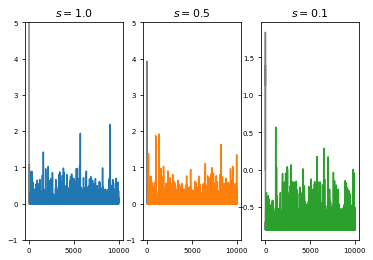

In [6]:
#Visualisation
fig, axes = plt.subplots(ncols=4)
axes[0].plot(list(state1_traj.index[:equilibration_steps]), state1_traj.totEnergy[:equilibration_steps], c="grey")
axes[0].plot(list(state1_traj.index[equilibration_steps:]), state1_traj.totEnergy[equilibration_steps:], c="C0")
axes[0].set_ylim([-1,5])
axes[0].set_title("$s = "+str(state1_traj.s[1])+"$")

axes[1].plot(list(state2_traj.index[:equilibration_steps]), state2_traj.totEnergy[:equilibration_steps], c="grey")
axes[1].plot(list(state2_traj.index[equilibration_steps:]), state2_traj.totEnergy[equilibration_steps:], c="C1")
axes[1].set_ylim([-1,5])
axes[1].set_title("$s =  "+str(state2_traj.s[1])+"$")

axes[2].plot(list(state3_traj.index[:equilibration_steps]), state3_traj.totEnergy[:equilibration_steps], c="grey")
axes[2].plot(list(state3_traj.index[equilibration_steps:]), state3_traj.totEnergy[equilibration_steps:], c="C2")
#axes[2].set_ylim([-1,5])
axes[2].set_title("$s =  "+str(state3_traj.s[1])+"$")

axes[3].plot(list(state4_traj.index[:equilibration_steps]), state3_traj.totEnergy[:equilibration_steps], c="grey")
axes[3].plot(list(state4_traj.index[equilibration_steps:]), state3_traj.totEnergy[equilibration_steps:], c="C2")
#axes[2].set_ylim([-1,5])
axes[3].set_title("$s =  "+str(state3_traj.s[1])+"$")


pass

### FEP-EDS_Evaluation

In [ ]:
print("SIMULATION 1")
print("\ts = ", s1)
positions = state1_traj.position[equilibration_steps:]
Vr = state1_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

print("SIMULATION 2")
print("\ts = ", s2)
positions = state2_traj.position[equilibration_steps:]
Vr = state2_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

print("SIMULATION 3")
print("\ts = ", s3)
positions = state3_traj.position[equilibration_steps:]
Vr = state3_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")


### BAR-EDS_Evaluation

In [ ]:
print("SIMULATION 3")
print("\ts = ", s3)
positions = state3_traj.position[equilibration_steps:]
Vr = state3_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)

#define states
V12 = [V1_x for V1_x, V2_x in zip(V1, V2) if (V1_x > V2_x)]
V22 = [V2_x for V1_x, V2_x in zip(V1, V2) if (V1_x > V2_x)]
V21 = [V2_x for V1_x, V2_x in zip(V1, V2) if (V1_x < V2_x)]
V11 = [V1_x for V1_x, V2_x in zip(V1, V2) if (V1_x < V2_x)]


#bar
bar = bennetAcceptanceRatio(kT=True)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dF_bar)
print()
print("\tDifference:", dF_bar - dG_expected)
print("\n\n\n")



In [ ]:
print("SIMULATION 1")
print("\ts = ", s3)
positions = state1_traj.position[equilibration_steps:]
Vr = state1_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)

#define states
V12 = [V1_x for V1_x, V2_x in zip(V1, V2) if (V1_x > V2_x)]
V22 = [V2_x for V1_x, V2_x in zip(V1, V2) if (V1_x > V2_x)]
V21 = [V2_x for V1_x, V2_x in zip(V1, V2) if (V1_x < V2_x)]
V11 = [V1_x for V1_x, V2_x in zip(V1, V2) if (V1_x < V2_x)]

print(len(V12), len(V11))

#bar
bar = bennetAcceptanceRatio(kT=True)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dF_bar)
print()
print("\tDifference:", dF_bar - dG_expected)
print("\n\n\n")



In [ ]:
print("SIMULATION 2")
print("\ts = ", s2)
positions = state2_traj.position[equilibration_steps:]
Vr = state2_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)

#define states
V12 = [V1_x for V1_x, V2_x in zip(V1, V2) if (V1_x > V2_x)]
V22 = [V2_x for V1_x, V2_x in zip(V1, V2) if (V1_x > V2_x)]
V21 = [V2_x for V1_x, V2_x in zip(V1, V2) if (V1_x < V2_x)]
V11 = [V1_x for V1_x, V2_x in zip(V1, V2) if (V1_x < V2_x)]

print(len(V12), len(V11))

#bar
bar = bennetAcceptanceRatio(kT=True)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dF_bar)
print()
print("\tDifference:", dF_bar - dG_expected)
print("\n\n\n")



In [ ]:
print("SIMULATION 1")
print("\ts = ", s1)
positions = state1_traj.position[equilibration_steps:]
Vr = state1_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)

#define states
V12 = V1
V22 = Vr
V21 = V2
V11 = Vr

print(len(V12), len(V11))

#bar
bar = bennetAcceptanceRatio(kT=True)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dF_bar)
print()
print("\tDifference:", dF_bar - dG_expected)
print("\n\n\n")



# Hybrid Methods - $\lambda-EDS $

In [ ]:
# 

# Enhanced Sampling with system Coupling

# RE-EDS

In [ ]:
#potential
Eoff = [0,0.65]
s=1
V_eds = pot.envelopedPotential(V_is=[h1, h2], s=s, Eoff_i=Eoff)

##Integrator
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

##System
eds_system = edsSystem(integrator=integrator, potential=V_eds)


##Ensemble
from ensembler.ensemble import replica_exchange
##Ensemble Settings:
s_values = np.logspace(start=0, stop=-1, num=3)
s_values = [100, 0.3, 0.1]
trials=20
steps_between_trials=simulation_steps_total_per_approach//(3*trials)

ensemble = replica_exchange.ReplicaExchangeEnvelopingDistributionSampling(system=eds_system, exchange_criterium=None, s_range=s_values, steps_between_trials=steps_between_trials)


In [ ]:
ensemble.simulate(trials, reset_ensemble=True)


In [ ]:
[replica.potential.s for repID, replica in ensemble.replicas.items()]

In [ ]:
trajs = ensemble.get_trajectories()

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(trajs, axes):
    ax.plot(positions, ensemble.replicas[traj].potential.ene(positions), c="grey")
    min_e = np.min(trajs[traj].totEnergy[eqil:])

    ax.scatter(trajs[traj].position[eqil:], trajs[traj].totEnergy[eqil:])
    ax.set_ylim([min_e-1,min_e+10])
    ax.set_xlim([-4,8])
    ax.set_title("replica"+str(traj))


In [ ]:
trajs = ensemble.get_trajectories()

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(trajs, axes):
    ax.hist(trajs[traj].position[eqil:])
    ax.set_xlim([-4,8])
    ax.set_title("replica"+str(traj))


In [ ]:

fig, ax = plt.subplots(ncols=1, figsize=[16,9])
enes = [trajs[x].totEnergy for x in sorted(trajs)] 
min_e = np.min(enes)
max_e = np.max(enes)

for ind, ene in enumerate(enes):
    ax.plot(ene, label="replica"+str(ind))
ax.vlines([steps_between_trials*x for x in range(trials)], ymin=min_e, ymax=max_e, label="exchange", lw=0.1)
ax.set_title("replica potE timeseries")
ax.set_ylim(1.1*min_e, 1.1*max_e)
ax.legend()

In [ ]:
stats= ensemble.exchange_information
replicas = np.unique(ensemble.exchange_information.replicaID)
trials = np.unique(ensemble.exchange_information.nExchange)

import itertools as it

fig, ax = plt.subplots(ncols=1, figsize=[16,9])

replica_positions = {}
for replica in replicas:
    replica_positions.update({replica: stats.loc[stats.replicaID==replica].replicaPositionI})

    x = trials
    y = replica_positions[replica]

    ax.plot(x,y , label="replica_"+str(replica))

#plt.yticks(replicas+1, reversed(replicas+1))
ax.set_yticks(ticks=replicas)
ax.set_yticklabels(labels=replicas)

ax.set_ylabel("replica Positions")
ax.set_xlabel("trials")
ax.set_title("Replica exchange transitions")
if(len(replicas)<10): plt.legend()

In [ ]:
#FREE E
equilibration_steps=100
print("Reeds Rep 0")
print("\ts = ", ensemble.exchange_dimensions['s'][0])
positions = trajs[0].position[equilibration_steps:]
Vr = trajs[0].totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")